# Imputación de datos faltantes

**Librerías**:

In [1]:
import janitor
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.graphics.mosaicplot import mosaic
import sklearn.impute
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
%run pandas-missing-extension.ipynb

## Preparando datos: _National Health and Nutrition Examination Survey_

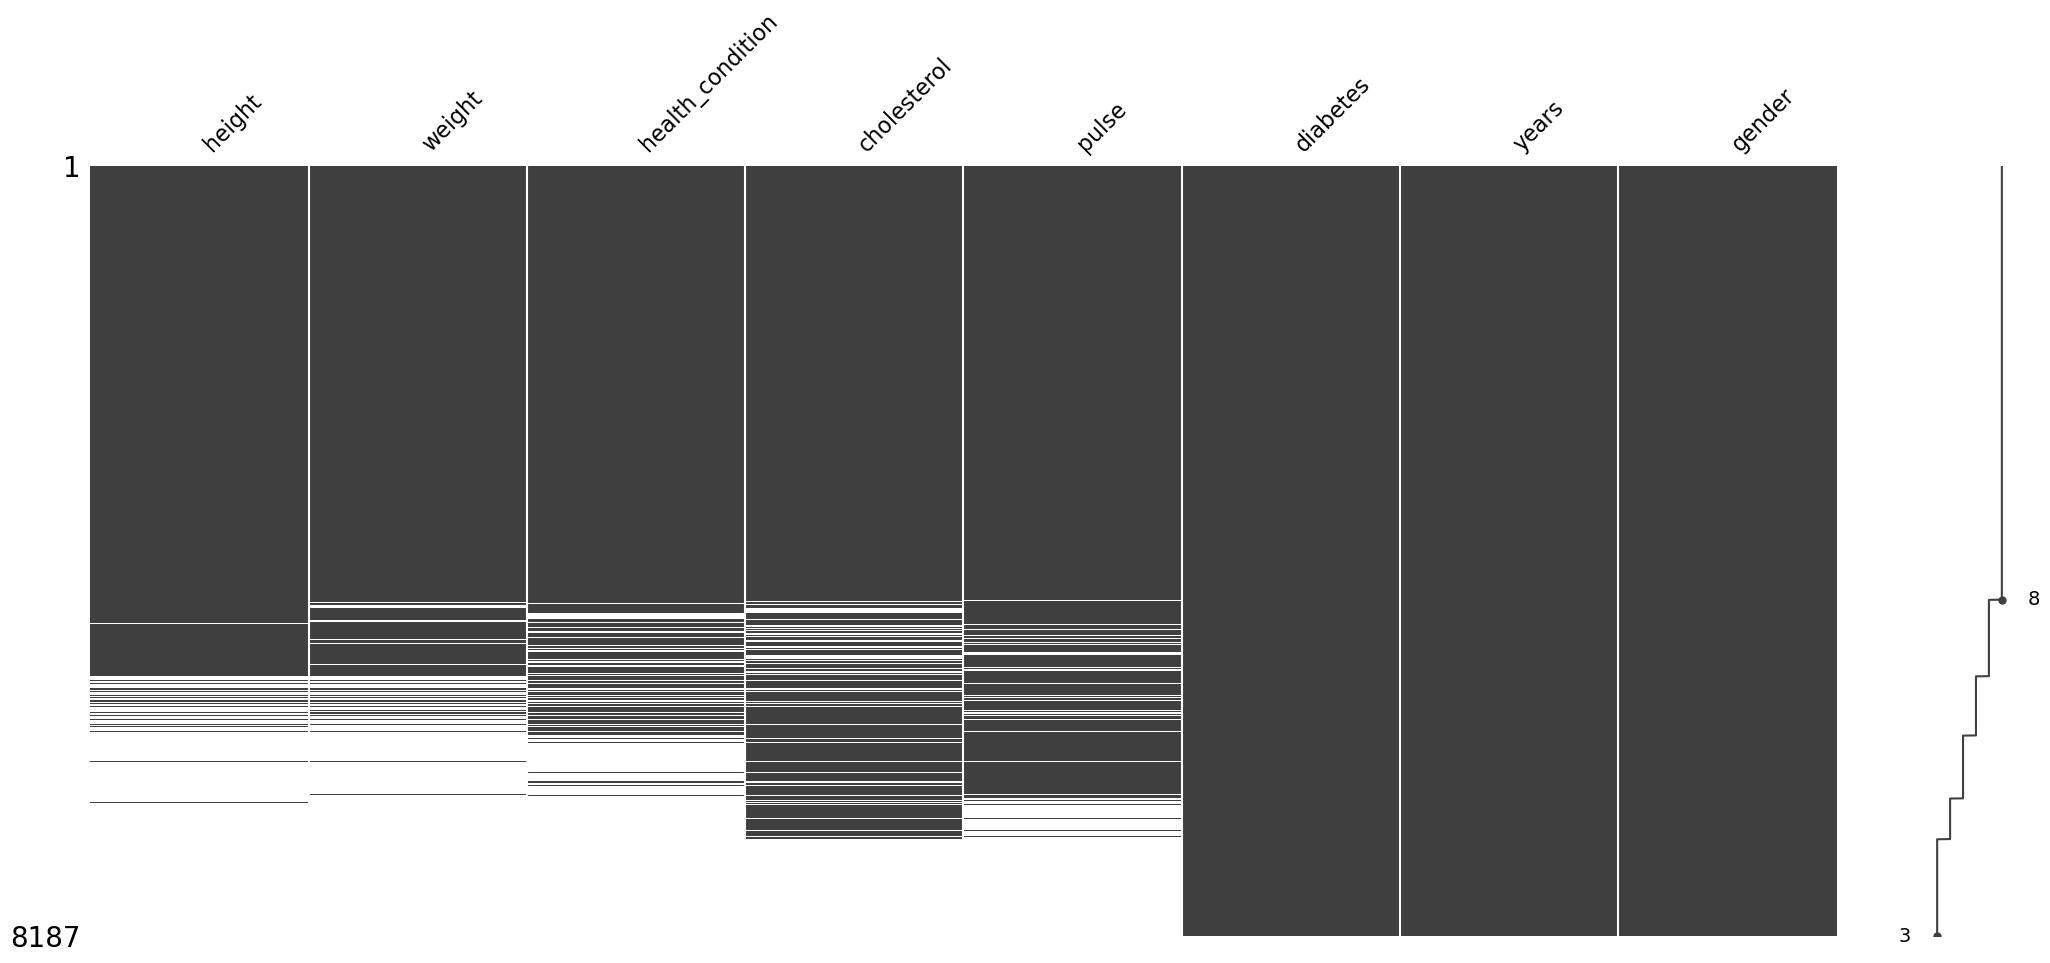

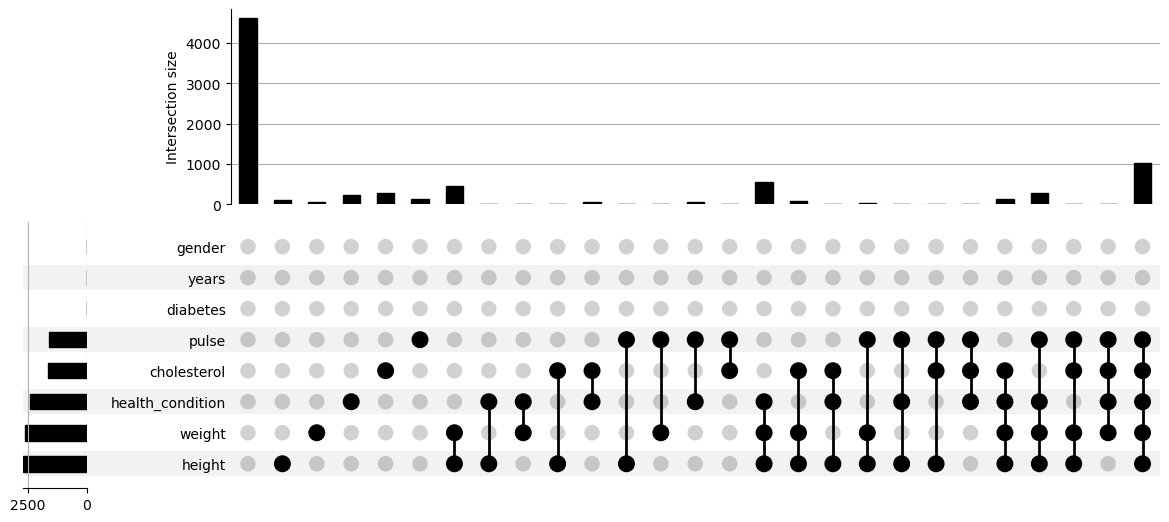

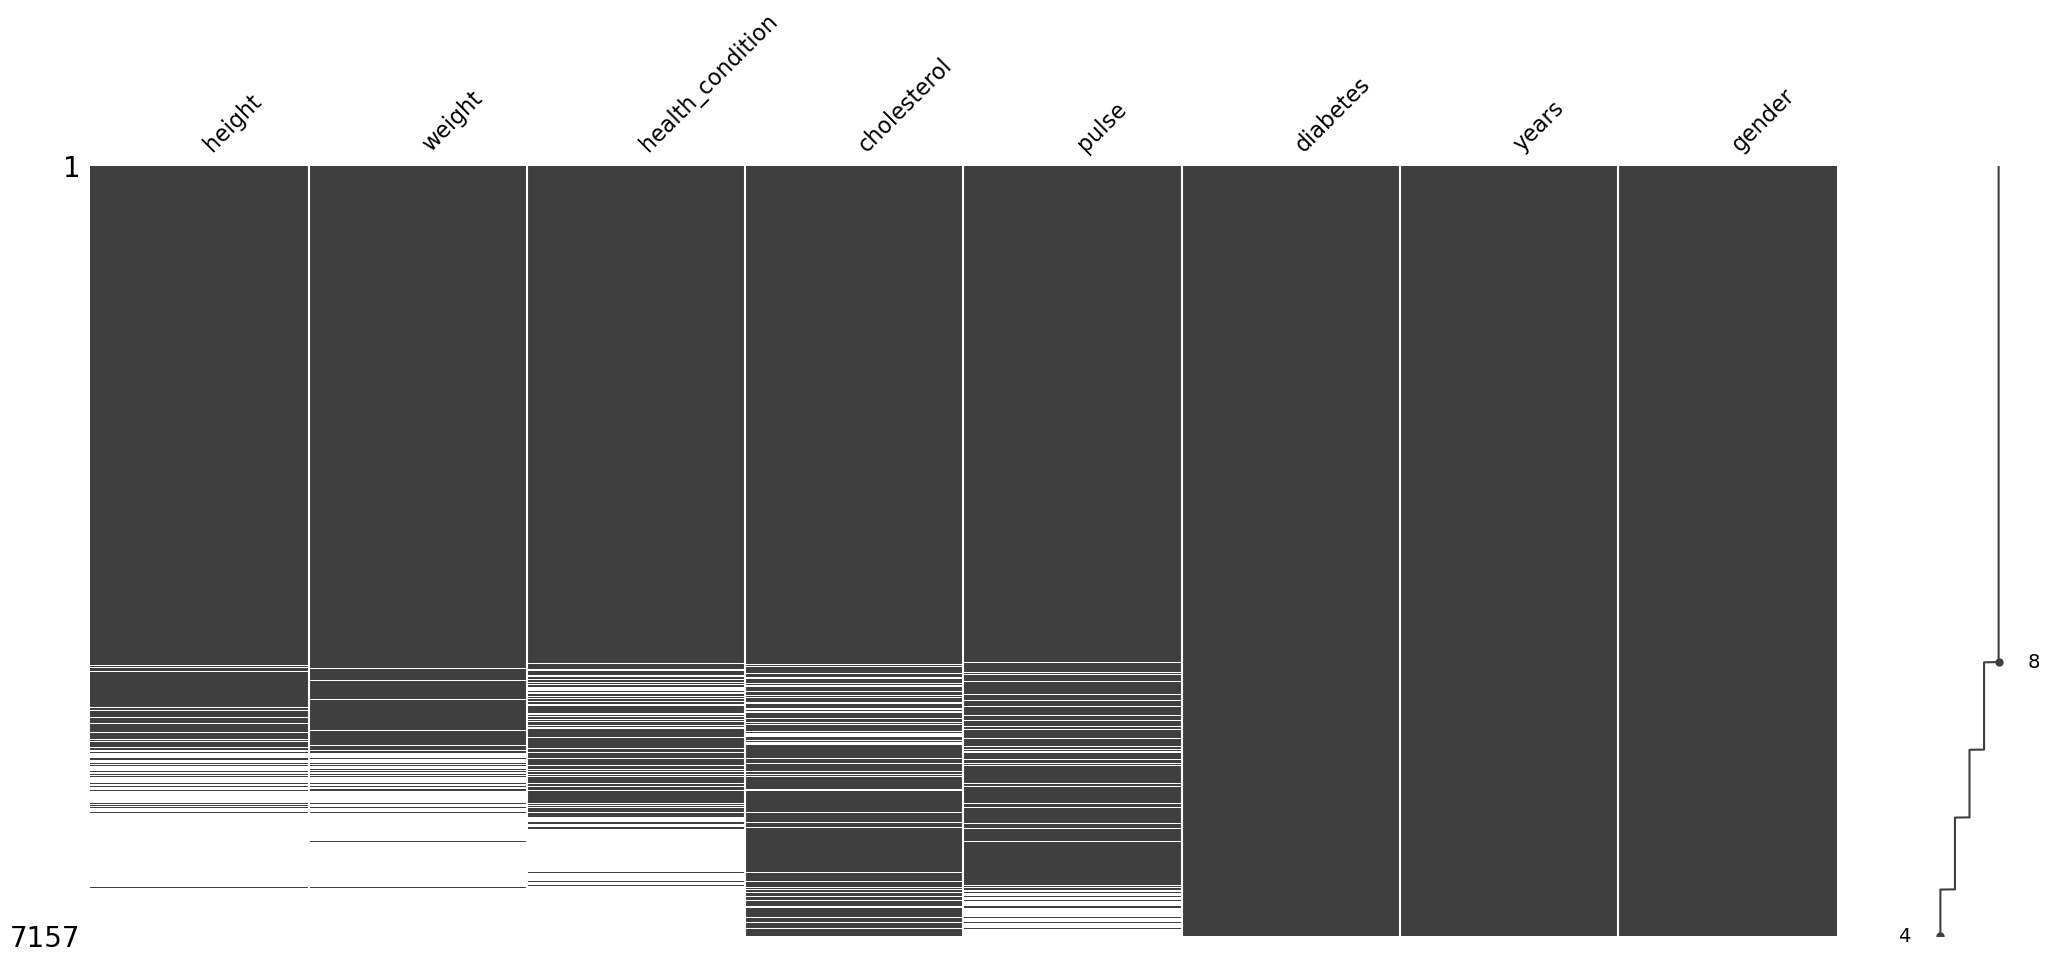

In [4]:
%run 2.1-Imputation_missing_values-data_loaded.ipynb

## Consideración y evaluación de los distintos tipos de valores faltantes

Existen tres tipos de mecanismos que generan valos faltantes al momento de la recolecció nde datos.

- Missing Completely At Random (**MCAR**): La localización de los valores faltantes en el conjunto de datos ocurre completamente al azar, no dependen de ningún otro dato.
- Missing At Random (**MAR**): La localización de los valores faltantes en el dataset depende de otros valores observados.
- Missing Not At Random (**MNAR**): La localización de los valores faltantes en el conjunto de datos depende de los valores faltantes en sí mismos.

Dependiendo del mecanismos que haya generado los valores faltantes en nuestro conjunto de datos, es el tratamiento que podemos darle, o mal menos nos da una idea de que podemos hacer.

![Missing data action](./imgs/missing_data_action.jpeg)

## Evaluación del mecanismo de valores faltantes por prueba de _t-test_

- `two-sided`: las **medias** de las distribuciones subyacentes a las muestras son **desiguales**
- `less`: la **media** de la distribución subyacente a la **primera** muestra es **menor** que la media de la distribución subyacente a la **segunda** muestra.
- `greater`: la **media** de la distribución subyacente a la **primera** muestra es **mayor** que la media de la distribución subyacente a la **segunda** muestra.


In [5]:
female_weight_df, male_weight_df = (
  nhanes_df
  .select_columns("gender", "weight")
  .transform_column(
    "weight",
    lambda x: x.isna(),
    elementwise = False
  )
  .groupby("gender")
  .weight
  .pipe(
    lambda df: (
      df.get_group("Female"),
      df.get_group("Male")
    )
  )
)

Para el ejemplo se quiere verificar si existe una diferencia entre la ausencia o presencia de valores en la medición del peso respecto a a categoría del genero.

Si obtenemos un $p\text-value$  $>0.05$ no se rechaza la hipotesis de que exista una diferencia en la media de las muestras.

In [6]:
ttest_ind(
  a = female_weight_df,
  b = male_weight_df,
  alternative = "two-sided"
)

TtestResult(statistic=-0.3621032192538131, pvalue=0.7172855918077239, df=7155.0)

Al hacer la prueba T-test obtenemos un $p\text-value$ de $0.1694 > 0.05$, por lo tanto no se rechaza la hipotesis de que existe una diferencia entre los pacientes que tienen valores faltantes en la medición del peso, se puede concluir que los valores faltantes de la variable `weight` son **MAR**.

## Visualización valores faltantes en variables categóricas

Buscaremos la relación entre la condición de salud (`health_condition`) y el genero (`gender`) en la ausencia de valores de la medición del peso (`weight`) del paciente.

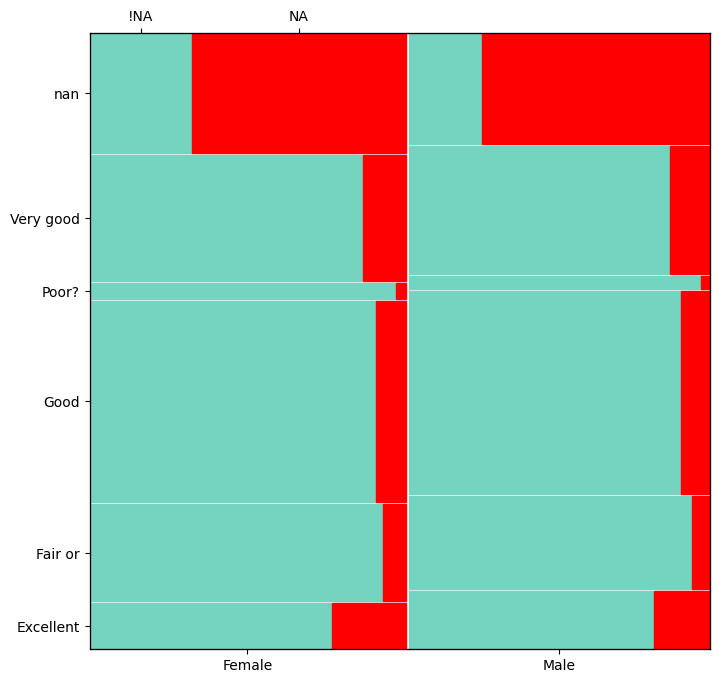

In [7]:
fig, ax = plt.subplots(figsize=(8,8))
(
  nhanes_df
  .select_columns("weight", "health_condition", "gender")
  .assign(
    weight = lambda df: df.weight.isna().replace([True, False], ["NA", "!NA"])
  )
  .groupby(
    ["gender", "health_condition", "weight"],
    dropna=False, # Visualizar los valores faltantes
    as_index=True # Regresa las variables agrupadas como Index.
  )
  .size()
  .pipe(
    lambda df: mosaic(
      data=df,
      properties=lambda key: {"color": "r" if "NA" in key else "#74d4c0"},
      axes_label=True,
      horizontal=True,
      labelizer=lambda key: "",
      ax=ax
    )
  )
);

Observaciones:
- Las personas (tanto hombres como mujeres) con una condición de salud pobre tienen la menor cantidad de valores faltantes en la medición del peso.
- Sin embargo, las personas con un estado de saludo Excelente son los que tienen mayor cantidad de valores faltantes en la medición del peso.
- En cambio cuando no esta registrada la condición salud podemos encontrar pocas mediciones de peso.

## Tratamiento de variables categóricas para imputación de valores faltantes

Creamos una copia independiente del DataFrame original para no modificar los datos una vez codificadas las variables categóricas.

In [8]:
nhanes_transform_df = nhanes_df.copy(deep=True)

### Codificación ordinal<a name=">orinal-encoder"></a>

Una codificación **ordinal** implica mapear cada categoría única en un valor numérico entero.

#### Ejemplo

Dado un dataset de datos con dos categorías, encontraremos los valores únicos por categoría y los transformaremos utilizando una códificación ordinal.

In [9]:
encoder = OrdinalEncoder() # Creamos una instancia del encoder.
X = [["Male"], ["Female"], ["Female"]]
X

[['Male'], ['Female'], ['Female']]

In [10]:
encoder.fit_transform(X) # Ajusta y transforma los datos

array([[1.],
       [0.],
       [0.]])

In [11]:
encoder.categories_ # Nos regresa las categorías que previamente codificó

[array(['Female', 'Male'], dtype=object)]

In [12]:
encoder.inverse_transform([[1], [0]])

array([['Male'],
       ['Female']], dtype=object)

#### Aplicando la codificación ordinal a todas las variables categóricas del DF

Seleccionamos las columnas categóricas que queremos transformar.

In [13]:
categorical_vars = nhanes_transform_df.select_dtypes(include=[object, "category"]).columns

Creamos el transformer que aplicará la codificación ordinal con la función `OrdinalEncoder`

In [14]:
categorical_transformer = make_column_transformer(
  (OrdinalEncoder(), categorical_vars),
  remainder="passthrough" # Le dice al coficiador que manenga intactas las otras columnas del DF 
)

Creamos un nuevo DF con las columnas categóricas ya codificadas.

In [15]:
nhanes_transform_df = (
  pd.DataFrame(
    categorical_transformer.fit_transform(nhanes_df),
    columns=categorical_transformer.get_feature_names_out(),
    index=nhanes_df.index
  )
  .rename_columns(
    function = lambda x: x.removeprefix("ordinalencoder__")
  )
  .rename_columns(
    function = lambda x: x.removeprefix("remainder__")
  )
)

#### Aplicando one-hot encoder <a name="one-hot-encoder"></a>

Copiamos el DataFrame original en otro espacio en memoria.

In [16]:
nhanes_OH_transformed_df = nhanes_df.copy(deep=True)

Creamos el transformer:
- A la variable categórica `gender` se le aplica una codificacióon ordinal al solo manejar dos categorías distintas,
- Aplicamos la codificación one-hot a la variable `health_condition` al manejar más categorías.

In [17]:
transformer = make_column_transformer(
  (OrdinalEncoder(), ["gender"]),
  (OneHotEncoder(), ["health_condition"]),
  remainder="passthrough"
)

In [18]:
nhanes_OH_transformed_df = (
  pd.DataFrame(
    transformer.fit_transform(nhanes_df),
    columns=transformer.get_feature_names_out(),
    index=nhanes_df.index
  )
  .rename_columns(
    function = lambda x: x.removeprefix("ordinalencoder__")
  )
  .rename_columns(
    function = lambda x: x.removeprefix("remainder__")
  )
  .rename_columns(
    function = lambda x: x.removeprefix("onehotencoder__")
  )
)

nhanes_OH_transformed_df.head(10)

,gender,health_condition_Excellent,health_condition_Fair or,health_condition_Good,health_condition_Poor?,health_condition_Very good,health_condition_nan,height,weight,cholesterol,pulse,diabetes,years
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,68.0,145.0,148.0,82.0,0.0,18.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,189.0,100.0,0.0,13.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,62.0,200.0,176.0,74.0,0.0,75.0
7,1.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0,142.0,238.0,62.0,0.0,56.0
8,1.0,0.0,0.0,1.0,0.0,0.0,0.0,68.0,135.0,182.0,68.0,0.0,18.0
9,1.0,0.0,0.0,0.0,0.0,1.0,0.0,70.0,165.0,184.0,90.0,0.0,67.0
10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,60.0,210.0,230.0,90.0,1.0,54.0
11,1.0,0.0,1.0,0.0,0.0,0.0,0.0,68.0,154.0,180.0,66.0,0.0,71.0
12,1.0,0.0,0.0,0.0,0.0,1.0,0.0,62.0,170.0,225.0,58.0,0.0,61.0


Ver las categorías que utilizóel transformador:

In [19]:
(
  transformer
  .named_transformers_
  .get("onehotencoder")
  .categories_
)

[array(['Excellent', 'Fair or', 'Good', 'Poor?', 'Very good', nan],
       dtype=object)]

Conocer una categoría por el valor codificado:

In [20]:
(
  transformer
  .named_transformers_
  .get("onehotencoder")
  .inverse_transform(
    X=[[0, 1, 0, 0, 0, 0]]
  )
)

array([['Fair or']], dtype=object)

## Métodos de imputación basados en el donante

Entre este tipo de métodos encontramos:
- Imputar una constante
- Imputar valores estadísticos: Media, moda o mediana
- Llenado hacia atrás
- Llenado hacia adelante
- Interpolación

### Imputación por interpolación

Este método de imputación es un proceso para estimar los puntos de los valores faltantes a partir de puntos conocidos mediante métodos de interpolación matemática.

La idea es utilizar los valores conocidos que están antes y después de un valor faltante para estimar su posible valor.

Importamos el conjunto de datos:

In [21]:
airquality_df = (
  sm.datasets.get_rdataset("airquality")
  .data
  .clean_names(
    case_type="snake",
  )
  .add_column("year", 1973)
  .assign(
    date = lambda df: pd.to_datetime(df[["year", "month", "day"]])
  )
  .sort_values(by="date")
  .set_index("date")
)
airquality_df

,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


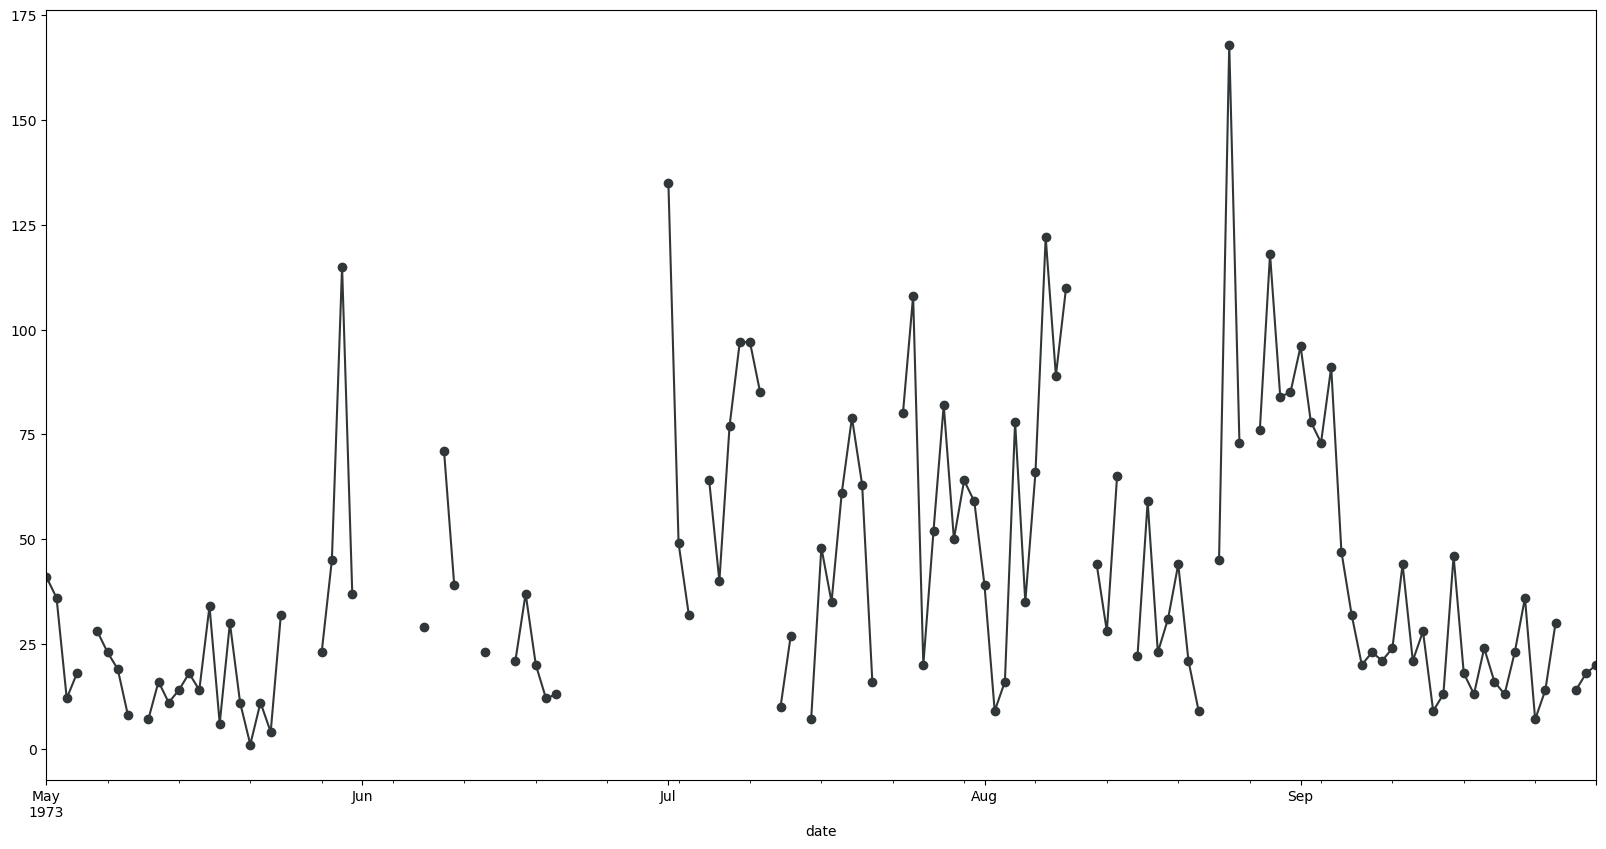

In [22]:
plt.figure(figsize=(20,10))
(
  airquality_df
  .select_columns("ozone")
  .pipe(
    lambda df: (
      df["ozone"].plot(color="#313638", marker="o")
    )
  )
)
plt.show()

En la serie temporal del valor de la variable `ozone` se observan cortes entre puntos, estos cortes indican la ausencia de valores en el dataset.

A continuación visualizamos una imputación con llenado hacia adelante y atrás:

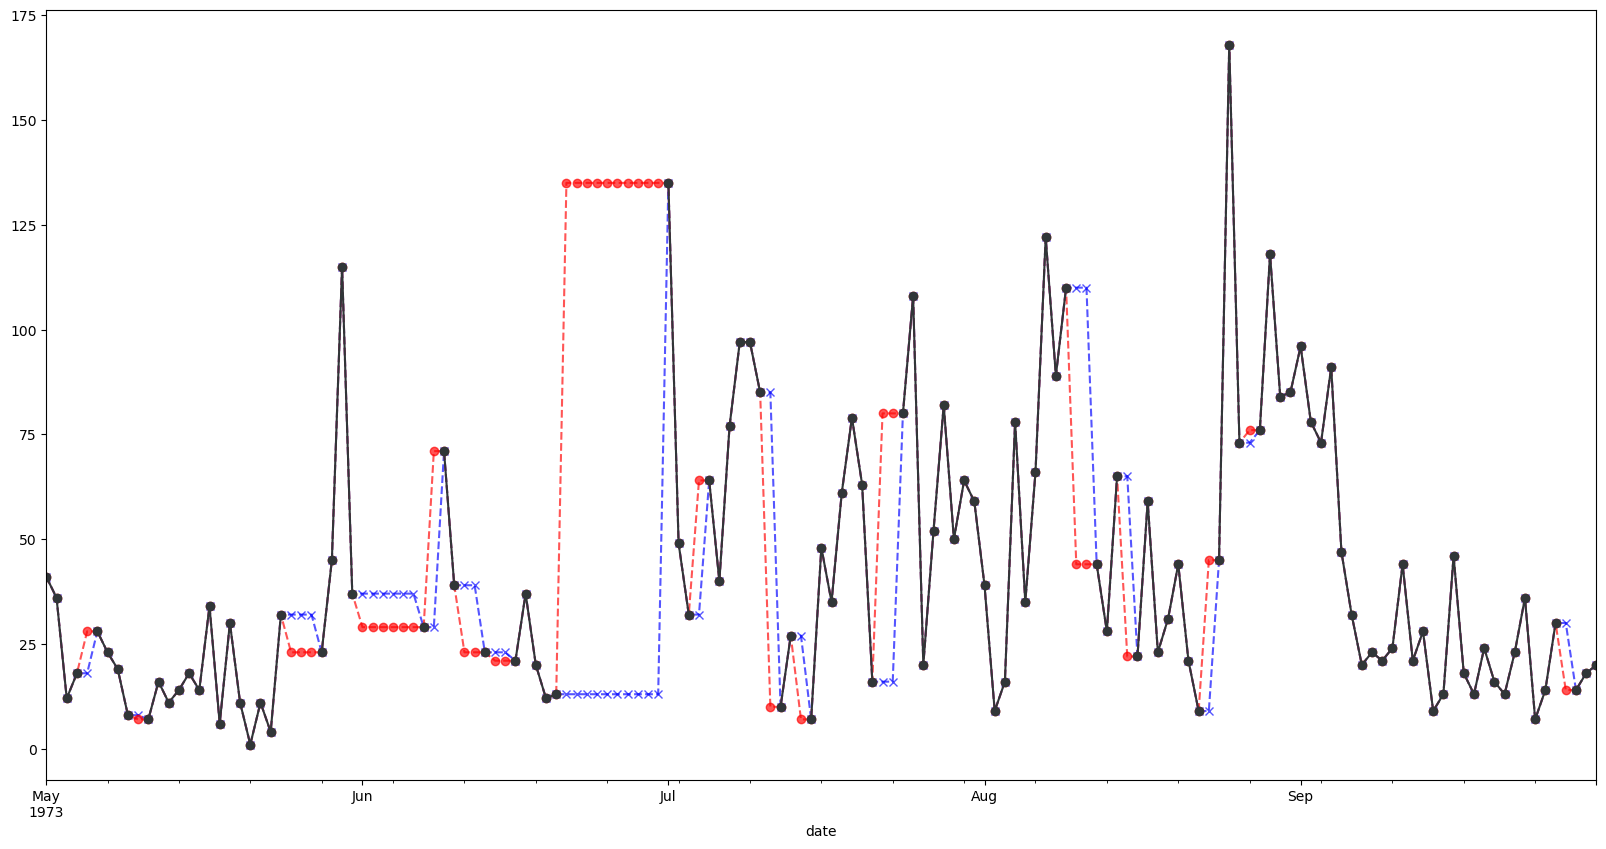

In [23]:
plt.figure(figsize=(20,10))

(
  airquality_df
  .select_columns("ozone")
  .pipe(
    lambda df: (
      df["ozone"].ffill().plot(color="b", alpha=6/9, linestyle="dashed", marker="x"),
      df["ozone"].bfill().plot(color="r", alpha=6/9, linestyle="dashed", marker="o"),
      df["ozone"].plot(color="#313638", marker="o")
    )
  )
)
plt.show()

Visualización de una imputación por interpolación lineal:

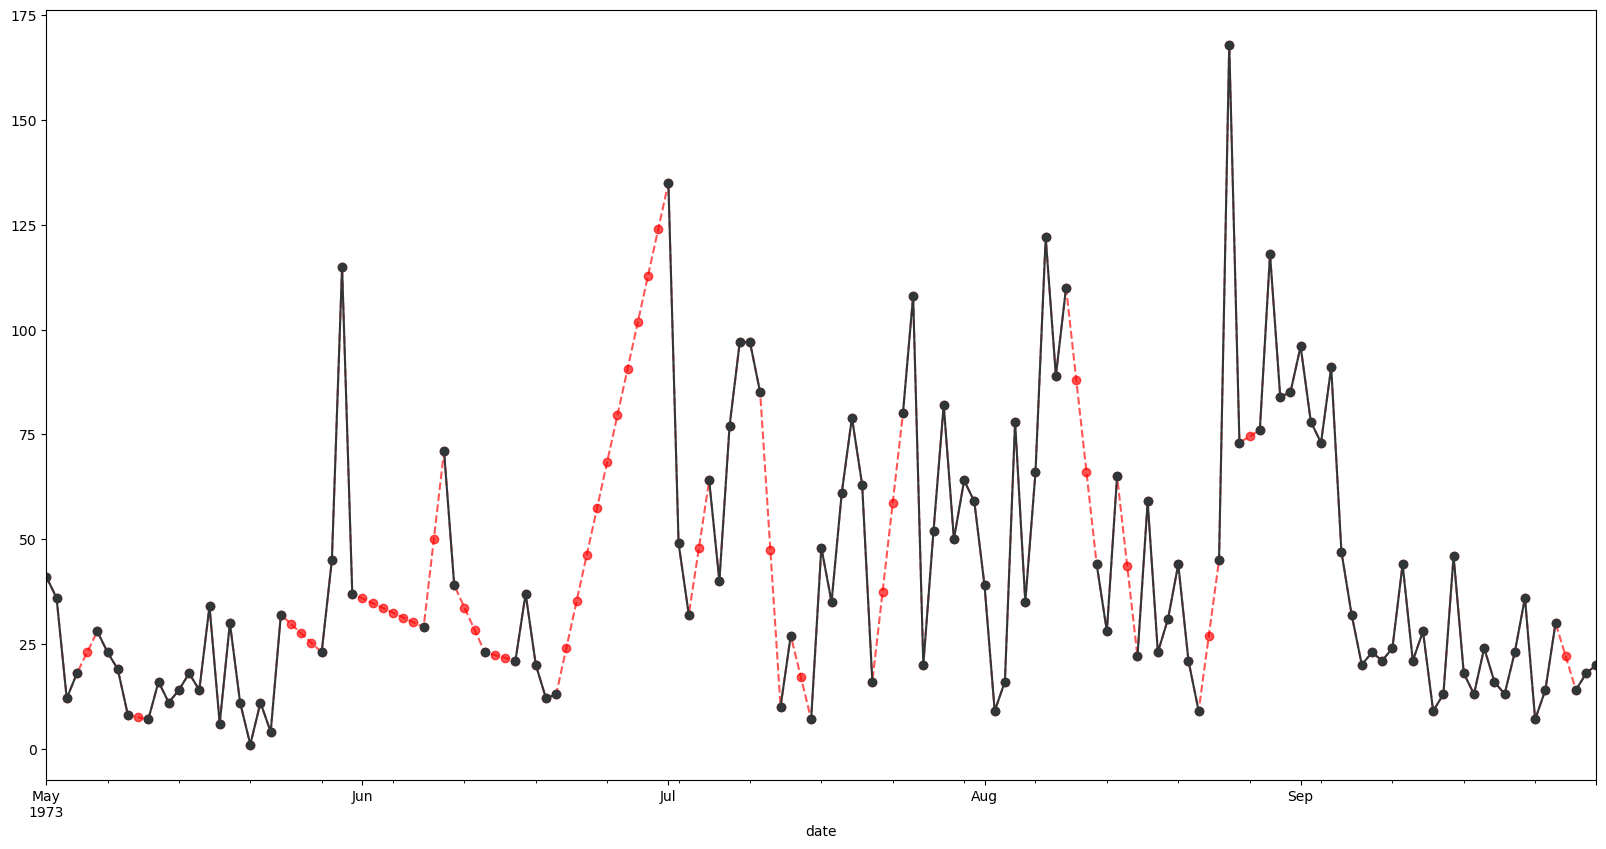

In [24]:
plt.figure(figsize=(20,10))

(
  airquality_df
  .select_columns("ozone")
  .pipe(
    lambda df: (
      df["ozone"].interpolate(method="linear").plot(color="r", alpha=6/9, linestyle="dashed", marker="o"),
      df["ozone"].plot(color="#313638", marker="o")
    )
  )
)
plt.show()

Visualización de una imputación por interpolación del vecino más cercano:

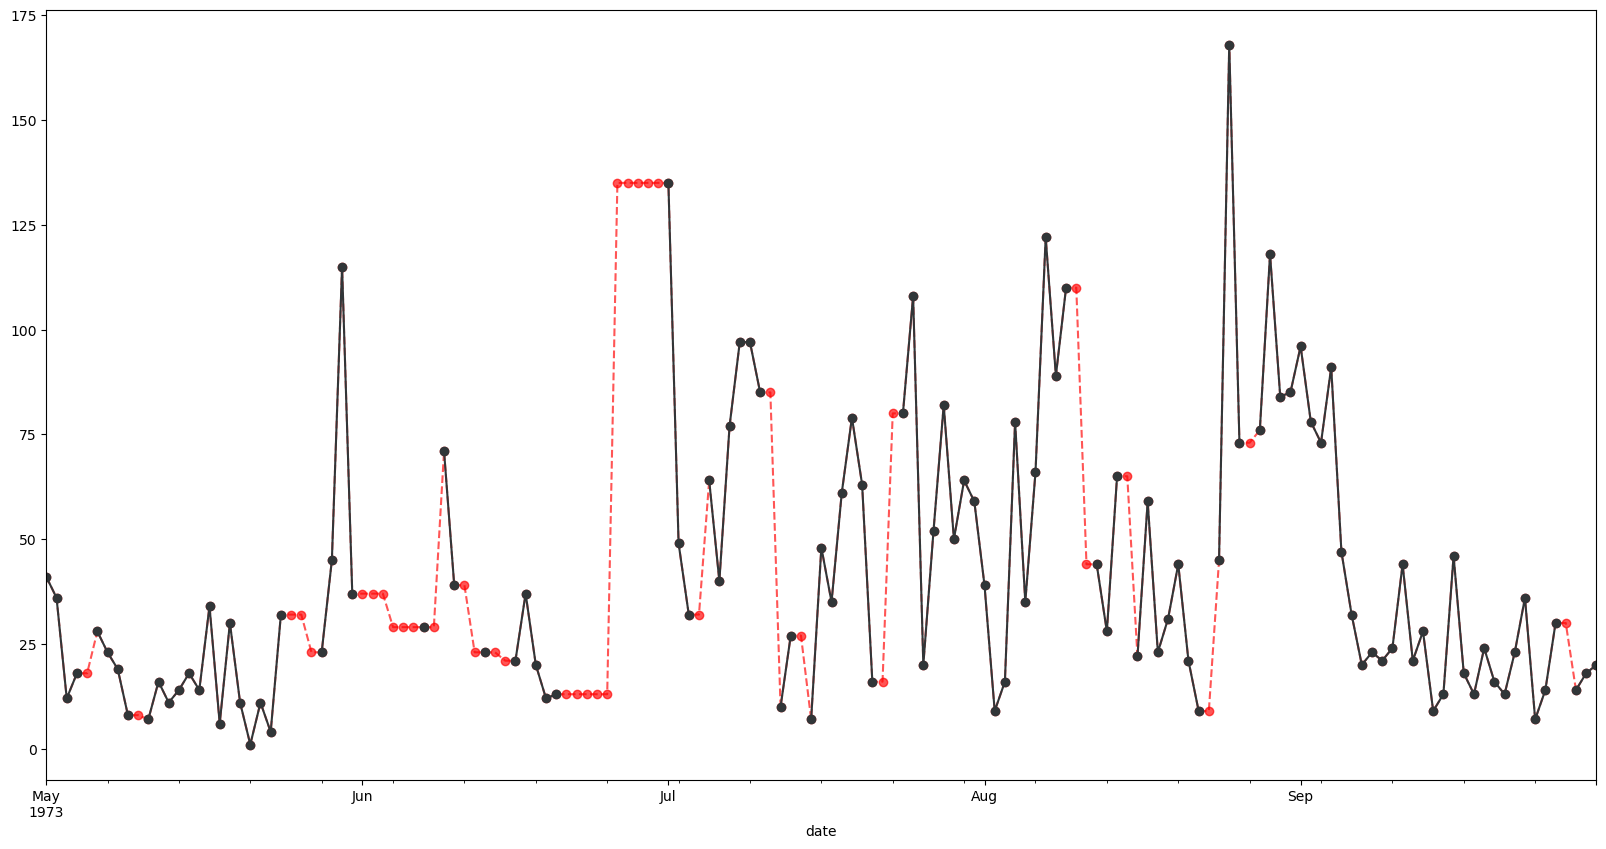

In [25]:
plt.figure(figsize=(20,10))

(
  airquality_df
  .select_columns("ozone")
  .pipe(
    lambda df: (
      df["ozone"].interpolate(method="nearest").plot(color="r", alpha=6/9, linestyle="dashed", marker="o"),
      df["ozone"].plot(color="#313638", marker="o")
    )
  )
)
plt.show()

Grácias a la previsualización de la interpolación aplicanto los método `linear` y `nearest`, podemos concluir que el mejor método o que más se ajusta a los datos es `linear` al no agregarle tanta variabilidad a los datos, entonces procedemos a imputar los datos a la variable `ozone` con este método.

In [26]:
airquality_df["ozone"] = airquality_df["ozone"].interpolate(method="nearest")
airquality_df["ozone"].isna().sum()

0

### Imputación por un único valor: media, moda o mediana

Esté tipo de imputación consiste en rellenar el valor faltante con el valor de la media/moda/mediana de la variable. <br>
Sin embargo utilizar esté metodo tiene tanto pros y contras: 

Pros:
1. Rápido y fácil.
2. La media puede ser útil en presencia de outliers.
3. No afectará el estadístico en cuestión (utilizado) ni el tamaño de la muestra.

Contras:
1. Puede sesgar los resultados, dado que modifica la distribución por debajo (curtosis).
2. Pierde correlaciones entre variables. No es preciso.
3. No puede usar variables categóricas (a excepción de la moda).

**Previsualización de la imputación de  datos en el DataFrame `nhanes` utilizando la media:**

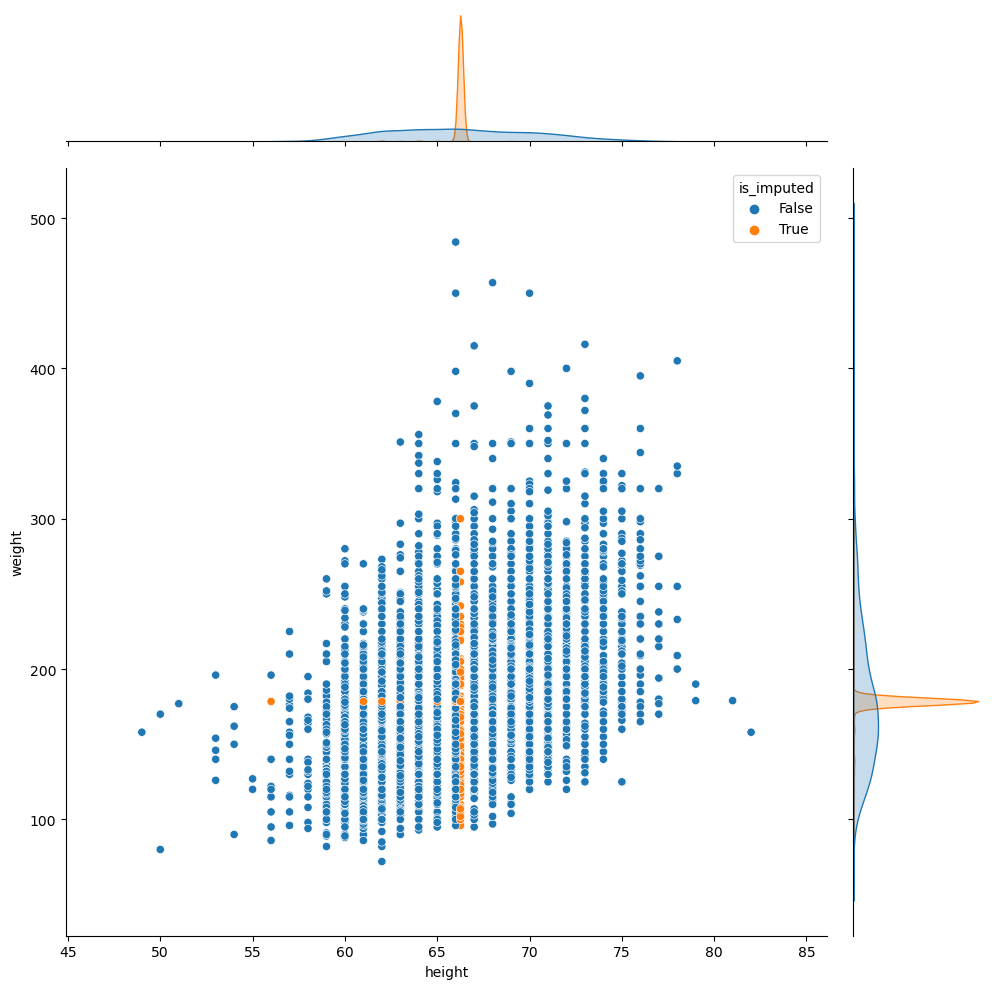

In [27]:
# plt.figure(figsize=(10,10))
(
  nhanes_df
  .select_columns("height", "weight")
  .missing.bind_shadow_matrix(True, False)
  .assign(
    height = lambda df: df["height"].fillna(df["height"].mean()),
    weight = lambda df: df["weight"].fillna(df["weight"].mean())
  )
  .missing.scatter_imputation_plot(
    x="height",
    y="weight",
    imputation_suffix="_NA",
    show_marginal=True,
    height=10
  )
);

### Imputación por llenado hacia adelante y hacia atrás

Este método de imputación consiste en:
- Rellenar valores faltantes utilizando el valor conocido inmediantemente después del valor faltante (llenado hacia atrás).
- O bien rellenar valores faltantes utilizando el valor conocido que esta justo antes del valor faltantes (llenado hacia delante).

**`ffill()`** y **`bfill()`**

**Previsualización de imputación de llenado hacia adelante**:

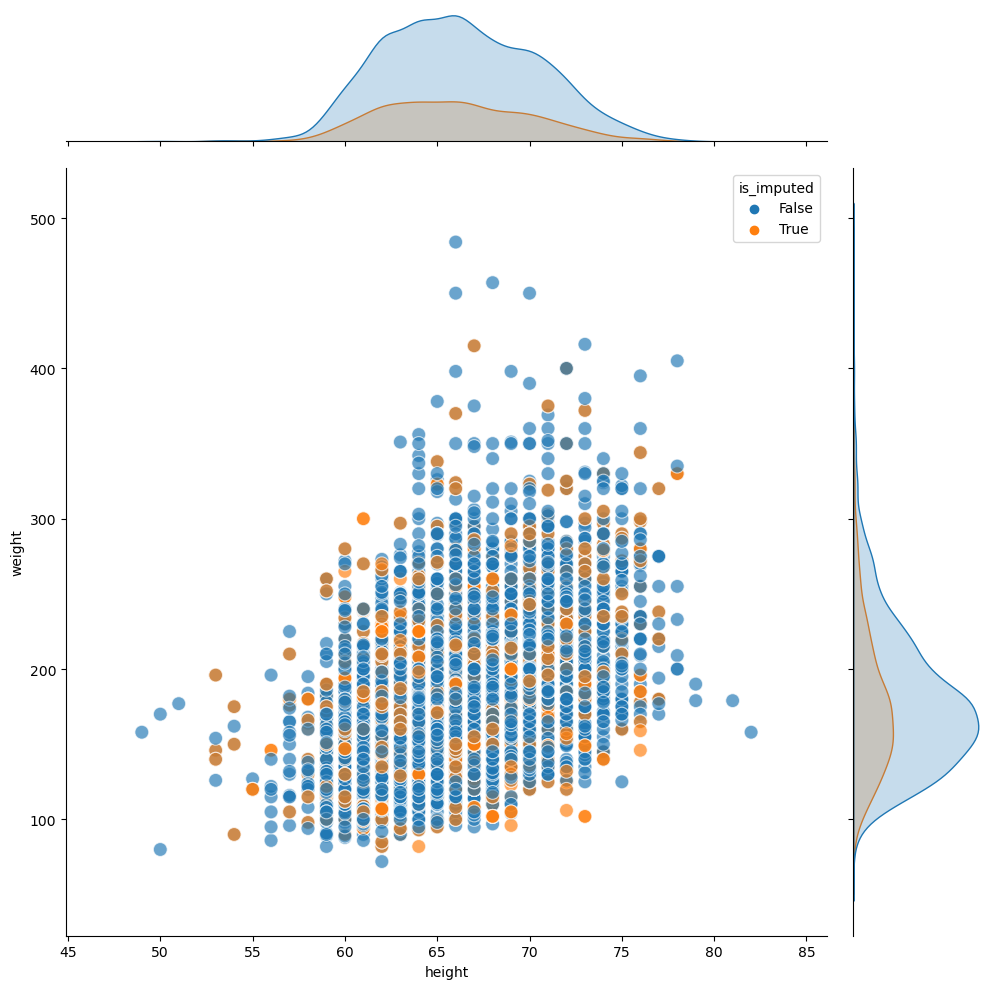

In [28]:
(
  nhanes_df
  .select_columns("height", "weight")
  .missing.bind_shadow_matrix(True, False)
  .ffill()
  .missing.scatter_imputation_plot(
    x="height",
    y="weight",
    imputation_suffix="_NA",
    show_marginal=True,
    height=10,
    alpha=6/9,
    s=100
  )
)

plt.show()

**Previsualización de imputación de llenado hacia atrás**:

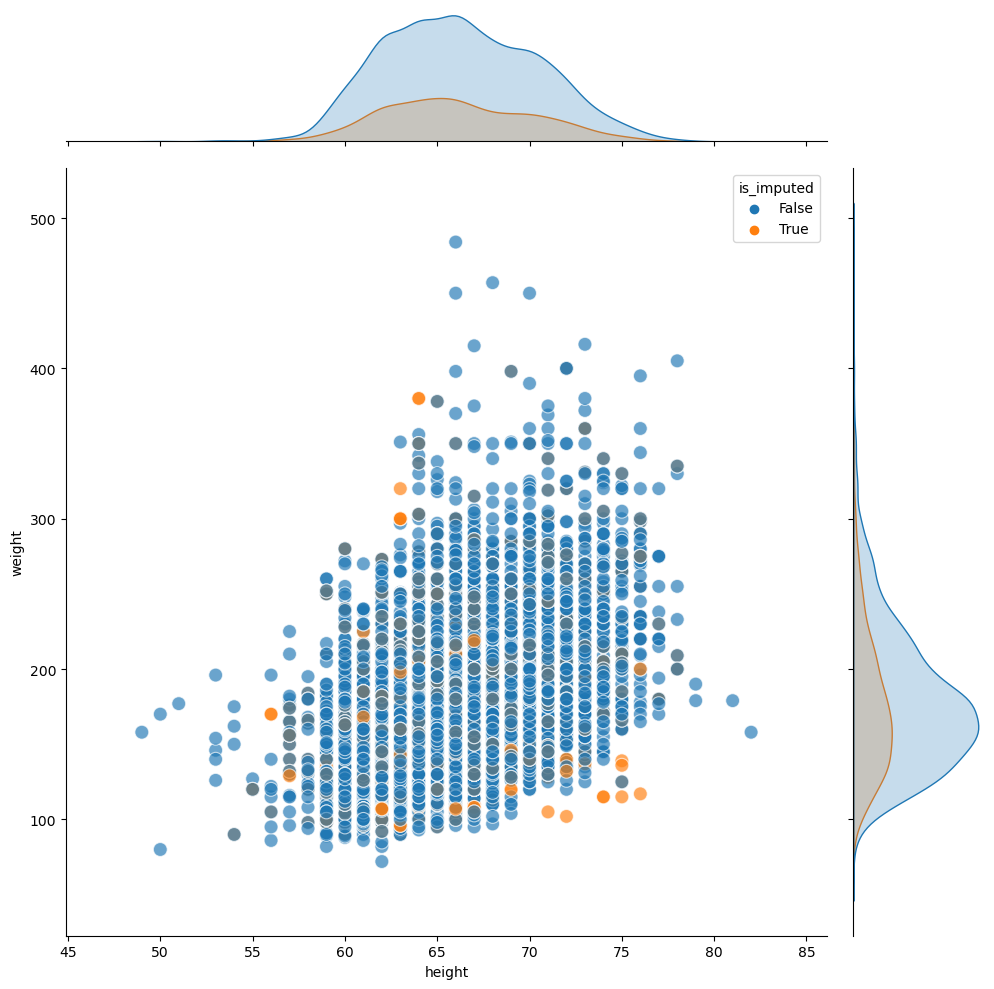

In [29]:
(
  nhanes_df
  .select_columns("height", "weight")
  .missing.bind_shadow_matrix(True, False)
  .bfill()
  .missing.scatter_imputation_plot(
    x="height",
    y="weight",
    imputation_suffix="_NA",
    show_marginal=True,
    height=10,
    alpha=6/9,
    s=100
  )
);
plt.show()

Al implementar este tipo de imputación podemos observar comportamientos distintos dependiendo de cual llenado utilicemos, especialmente cuando las variables a imputar estan correlacionadas con otras variables, o bien cuando estan influenciadas por variables categóricas.

**Ejemplo**: Las variables `weight` y `height` estan correlacionadas a la variable categórica `gender`.
- La altura sea menor cuando los pacientes son mujeres.
- El peso sea mayor cuando los pacientes sean hombres.


📌 **NOTA**: Se le llama "_dominio_" a la variable o variables categóricas a partir de las cuales se le aplica un orden especifico a los datos para realizar el llenado hacia adelante o hacia atrás.

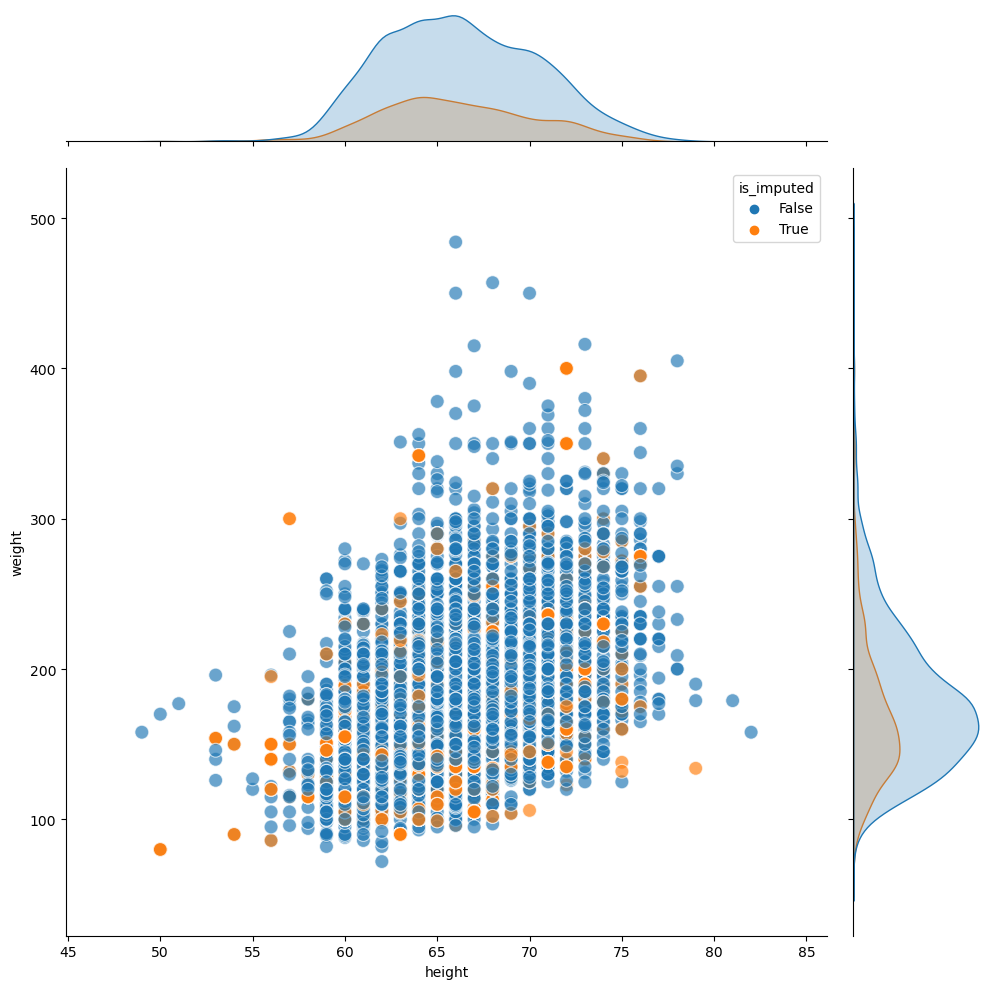

In [30]:
(
  nhanes_df
  .select_columns("height", "weight", "gender", "diabetes", "health_condition")
  .missing.bind_shadow_matrix(True, False)
  .sort_values(
    by=["gender", "diabetes", "health_condition"],
    ascending=True
  )
  .transform_column(
    "weight",
    lambda x: x.ffill(),
    elementwise=False
  )
  .transform_column(
    "height",
    lambda x: x.ffill(),
    elementwise=False
  )
  .missing.scatter_imputation_plot(
    x="height",
    y="weight",
    imputation_suffix="_NA",
    show_marginal=True,
    height=10,
    alpha=6/9,
    s=100
  )
);
plt.show()

### Imputación por el algoritmo **`KNN`**

**`KNN`**: K-Vecinos más cercanos (K-nearest neighbors) 

Es un algoritmo de machine learning para clasificación. Consiste en predecir un punto de datos basándose en la mayoría de los vecinos (k) más cercanos.

En la imputación de datos, calcula un valor estadístico (media ó mediana) a partir de los vecinos más cercanos y el resultado lo coloca donde esta el valor faltante correspondiente.

📌 Para implementar el algoritmo `KNN` las variables categóricas a imputar deberán estar previamente codificadas, ya sea con [`orinal encoder`](#orinal-encoder) o con [`one-hot encoder`](#one-hot-encoder).

In [31]:
knn_imputer = sklearn.impute.KNNImputer() # Creamos una instancia del algoritmo KNN para imputar datos.

nhanes_df_knn = nhanes_transform_df.copy(deep=True) # Copia del DF codificado para no modificar los datgos originales

nhanes_df_knn.iloc[:, :] = knn_imputer.fit_transform(nhanes_transform_df).round() # Ejecuta la imputación de los datos contenidos en el DF que nhanes_transform_df.
nhanes_df_knn

,health_condition,gender,height,weight,cholesterol,pulse,diabetes,years
2,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
3,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
4,2.0,1.0,69.0,130.0,189.0,100.0,0.0,13.0
6,2.0,0.0,62.0,200.0,176.0,74.0,0.0,75.0
7,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
8359,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
8362,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
8363,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0
8364,4.0,0.0,71.0,159.0,150.0,74.0,0.0,14.0


📝 La función `knn_imputer.fit_transform().` retorna un array de `numpy`, los resultados estan en el mismo orden que en el dataframe, para asignarlo al DataFrame con el que queremos trabajar lo hacemos con la funcionalidad `iloc` de pandas, indicandole que sustituiremos los valores tanto de filas y columnas `[:, :]` con el nuevo array.


📌 Al aplicar `iloc[:, :]` reemplazamos todos los valores pero concervamos las columnas.

**Visualización de la imputación de datos con el algoritmos `KNN`:**

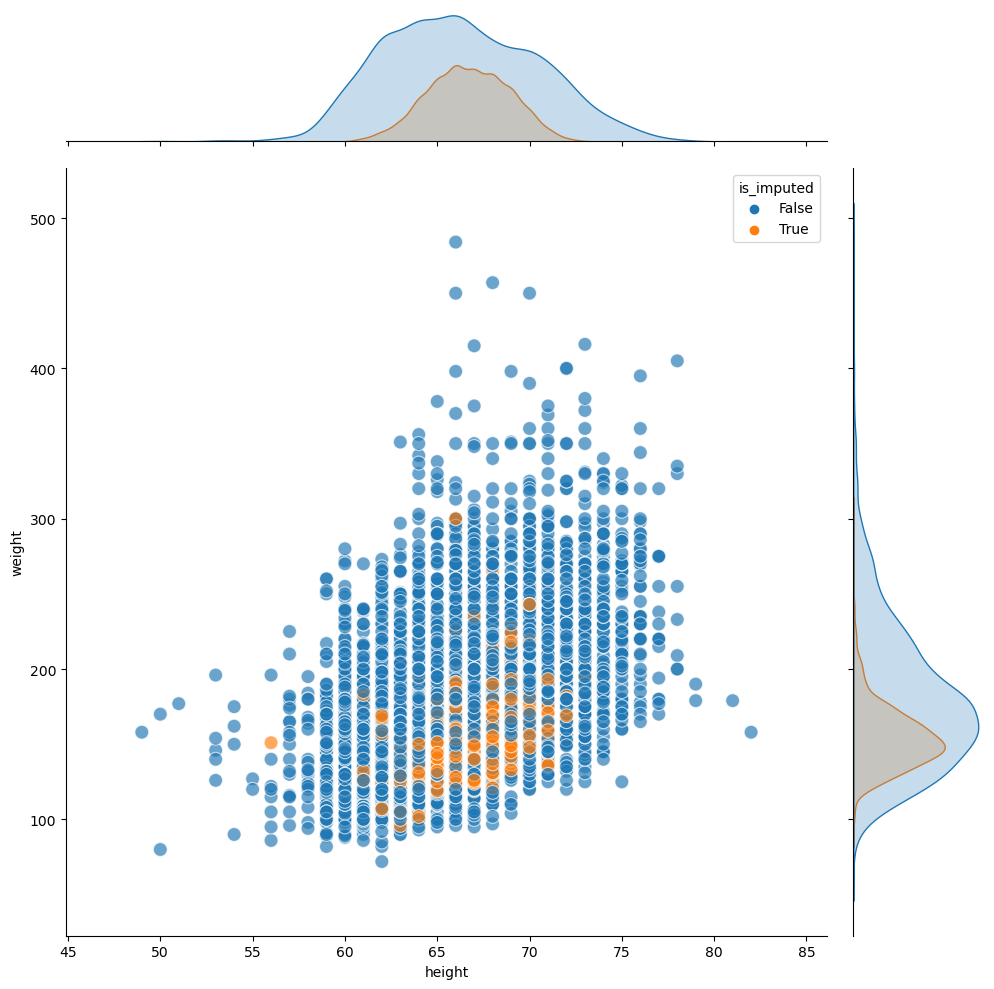

In [32]:
(
  pd.concat(
    [
      nhanes_df_knn,
      nhanes_df.missing.create_shadow_matrix(True, False, only_missing=True)
    ],
    axis=1
  )
  .missing.scatter_imputation_plot(
    x="height",
    y="weight",
    imputation_suffix="_NA",
    show_marginal=True,
    height=10,
    alpha=6/9,
    s=100
  )
)

## Imputación basada en modelos

Este tipo de imputación es una técnica que utiliza modelos de machine learning para estimar o completar valores faltantes en un conjunto de datos.


Los modelos utilizan las relaciones entre las variables para predecir o estimar los valores faltantes de manera más precisa preservando las relaciones entre las variables.

Sin emabrgo imputar datos mediante modelos es más complejo y engorroso (largo) en comparación con los metodos basados en el donante. 

⚠️ Es importante tener en cuenta que a mayor cantidad de variables en el conjunto de datos, el proceso de imputación es más costoso.

### Imputación con el modelo de regresión lineal.

Para este ejercicio se quiere imputar la variable `height` a partir de las variables `weight`, `gender` y `years`.

Pasos para imputar con un modelo de regresión lineal:
1. Seleccionamos las variables que van influir en la predicción de los valores faltantes de la variable a imputar.
2. Ordenamos el conjunto de datos a partir de la variable a predecir.
3. Rellenamos de valores dummies la variable independiente (cuando tiene valores faltantes); el modelo no puede hacer una predicción certera con valores faltantes.
4. (OPCIONAL) Agregar matriz de sombras; el objetivo es identificar los valores imputados para graficarlos y segmentarlos entre imputados y reales.
5. Creamos el modelo indicando la variable a predecir seguida de sus predictoras (variables que la describen).
6. Seleccionamos los valores faltantes de la variable a predecir del conjunto de datos previamente ordenado.
7. Implementamos el modelo de predicción.
8. Imputamos los valores faltantes con los obtenidos del modelo.
9. (OPCIONAL) Graficar el resultado en un `scatterplot`.

In [33]:
nhanes_model_df = (
  nhanes_df
  .select_columns("height", "weight", "gender", "years") # 1. Selección de variables
  .sort_values(by="height") # Ordenamiento por variable a predecir
  .transform_column( # 3. Rellenar de valores dummies
    "weight",
    lambda x: x.ffill(),
    elementwise=False
  )
  .missing.bind_shadow_matrix(True, False) # 4. Agremamos la matriz de sombras
)
nhanes_model_df

,height,weight,gender,years,height_NA,weight_NA,gender_NA,years_NA
1122,49.0,158.0,Female,80.0,False,False,False,False
2546,50.0,170.0,Female,46.0,False,False,False,False
3775,50.0,80.0,Female,29.0,False,False,False,False
7847,51.0,177.0,Female,71.0,False,False,False,False
108,53.0,146.0,Female,80.0,False,False,False,False
...,...,...,...,...,...,...,...,...
8331,NaN,107.0,Female,14.0,True,False,False,False
8341,NaN,107.0,Female,15.0,True,False,False,False
8352,NaN,107.0,Female,14.0,True,False,False,False
8355,NaN,107.0,Male,15.0,True,False,False,False


In [34]:
height_ols = smf.ols( # 6. Creamos el modelo de regresión lineal
  "height ~ weight + gender + years",
  data=nhanes_model_df
).fit()

In [35]:
ols_predicted_values = (
  nhanes_model_df
  .pipe(
    lambda df: df[df.height.isna()] # Seleccionamos unicamente los valores faltantes de la variable a predecir
  )
  .pipe(
    lambda df: height_ols.predict(df).round() # Aplicamos el modelo de preducción
  )
)
ols_predicted_values

4       69.0
15      64.0
29      64.0
31      69.0
32      69.0
        ... 
8331    63.0
8341    63.0
8352    63.0
8355    68.0
8364    63.0
Length: 1669, dtype: float64

In [36]:
# Imputamos los valores obtenidos del modelo.
nhanes_model_df.loc[nhanes_model_df.height.isna(), ["height"]] = ols_predicted_values
nhanes_model_df

,height,weight,gender,years,height_NA,weight_NA,gender_NA,years_NA
1122,49.0,158.0,Female,80.0,False,False,False,False
2546,50.0,170.0,Female,46.0,False,False,False,False
3775,50.0,80.0,Female,29.0,False,False,False,False
7847,51.0,177.0,Female,71.0,False,False,False,False
108,53.0,146.0,Female,80.0,False,False,False,False
...,...,...,...,...,...,...,...,...
8331,63.0,107.0,Female,14.0,True,False,False,False
8341,63.0,107.0,Female,15.0,True,False,False,False
8352,63.0,107.0,Female,14.0,True,False,False,False
8355,68.0,107.0,Male,15.0,True,False,False,False


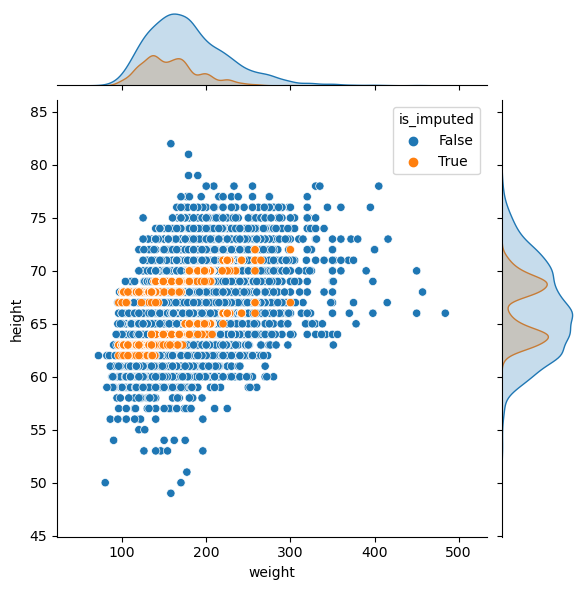

In [37]:
(
  nhanes_model_df
  .missing
  .scatter_imputation_plot( # 9. Gráficamos el resultado
    x="weight",
    y="height",
    show_marginal=True,
    imputation_suffix="_NA"
  )
)
plt.show()

### Imputaciones Múltiples por Ecuaciones Encadenadas (MICE)

El algoritmo MICE utiliza modelos estadísticos para predecir los valores faltantes en un conjunto de datos, iterando sobre las variables con valores faltantes y ajustando modelos separados para cada una de ellas. Este enfoque permite imputar valores faltantes de manera precisa y capturar la incertidumbre asociada con la imputación.

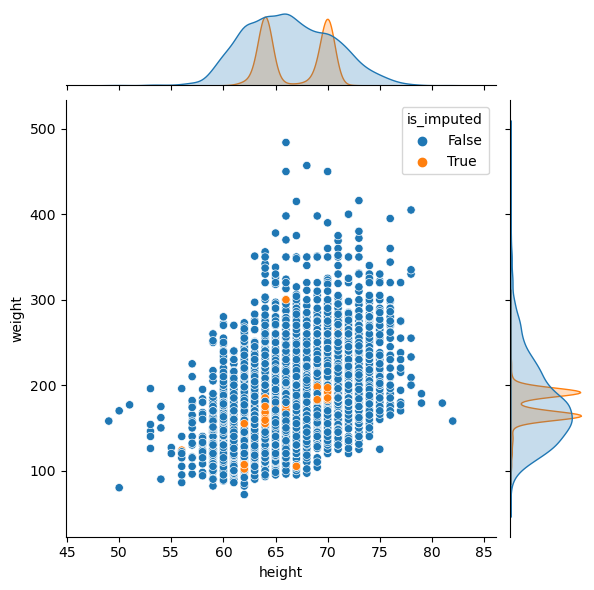

In [38]:
mice_imputer = sklearn.impute.IterativeImputer(
  estimator=BayesianRidge(),
  initial_strategy="mean",
  imputation_order="ascending"
)

nhanes_mice_df = nhanes_transform_df.copy(deep=True)
nhanes_mice_df.iloc[:, :] = mice_imputer.fit_transform(nhanes_transform_df).round()

nhanes_mice_df = pd.concat(
  [
    nhanes_mice_df,
    nhanes_df.missing.create_shadow_matrix(True, False)
  ],
  axis=1
)

nhanes_mice_df.missing.scatter_imputation_plot(
  x="height",
  y="weight",
  imputation_suffix="_NA",
  show_marginal=True
)